데이터 로딩 중...
원본 데이터 형태: Features=(50910, 5, 62), Labels=(50910,)
전처리 후 데이터: (34350, 310)
클래스 분포: 부정(0)=16800, 긍정(1)=17550

[데이터 분할 완료]
타인 데이터(학습용): 32060개
나의 데이터(검증용): 2290개

1. 일반 모델 (타인 데이터로 학습 -> 내 감정 맞추기)
General Model 정확도: 0.5009 (50.09%)

상세 리포트:
              precision    recall  f1-score   support

    Negative       0.49      1.00      0.66      1120
    Positive       1.00      0.02      0.05      1170

    accuracy                           0.50      2290
   macro avg       0.75      0.51      0.35      2290
weighted avg       0.75      0.50      0.35      2290


2. 개인화 모델 (타인 + 내 데이터 일부 학습)
Personalized Model 정확도: 0.5420 (54.20%)


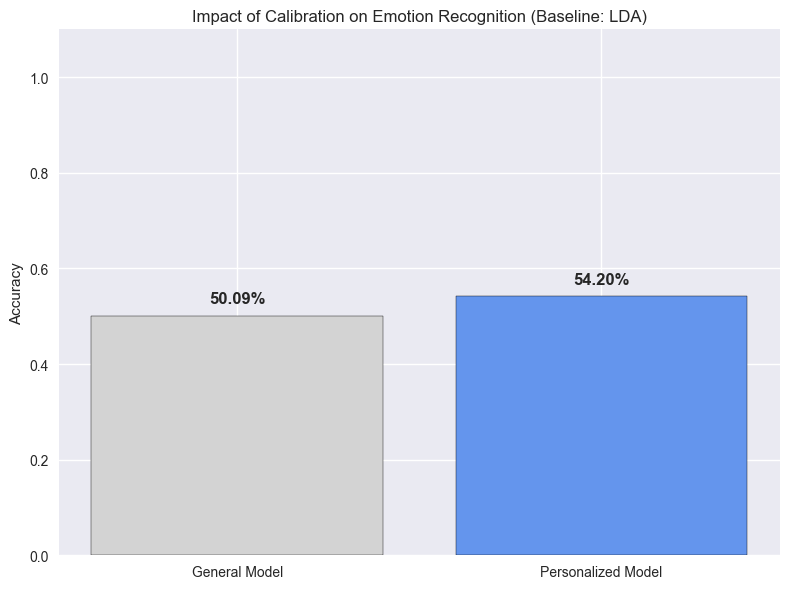

개인화(Calibration) 적용 시 정확도가 4.12%p 향상


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

plt.style.use('seaborn-v0_8')

# 1. 데이터 로드 및 전처리
def load_and_preprocess_data(dataset_path, labels_path, subjects_path):
    print("데이터 로딩 중...")
    
    features = np.load(dataset_path)['arr_0'] 
    labels = np.load(labels_path)['arr_0']     
    subjects = np.load(subjects_path)['arr_0']  
    
    print(f"원본 데이터 형태: Features={features.shape}, Labels={labels.shape}")
    
    # 1) 데이터 펼치기 (Flattening)
    # 머신러닝(LDA) 입력을 위해 (5개 대역 x 62채널)을 1차원(310개)으로 변환
    X = features.reshape(features.shape[0], -1) # (Samples, 310)
    
    # 2) 라벨 필터링 
    # 중립(1) 제거, 긍정(2) -> 1, 부정(0) -> 0
    
    # 중립(1)이 아닌 인덱스 찾기
    valid_idx = np.where(labels != 1)[0]
    
    X_filtered = X[valid_idx]
    y_filtered = labels[valid_idx]
    sub_filtered = subjects[valid_idx]
    
    # 긍정 라벨 변환 (2 -> 1)
    y_filtered = np.where(y_filtered == 2, 1, y_filtered)
    
    print(f"전처리 후 데이터: {X_filtered.shape}")
    print(f"클래스 분포: 부정(0)={np.sum(y_filtered==0)}, 긍정(1)={np.sum(y_filtered==1)}")
    
    return X_filtered, y_filtered, sub_filtered

# 2. 실행

dataset_file = 'DatasetCaricatoNoImage.npz'
labels_file = 'LabelsNoImage.npz'
subjects_file = 'SubjectsNoImage.npz'

# 데이터 로드
X, y, subjects = load_and_preprocess_data(dataset_file, labels_file, subjects_file)

# 데이터 분할: 나(Subject 0) vs 타인(Subject 1~14)
target_subject_id = 0 # 0번 피험자

# 타인 데이터 (Source Domain)
source_idx = np.where(subjects != target_subject_id)[0]
X_source = X[source_idx]
y_source = y[source_idx]

# 나의 데이터 (Target Domain)
target_idx = np.where(subjects == target_subject_id)[0]
X_target = X[target_idx]
y_target = y[target_idx]

print(f"\n[데이터 분할 완료]")
print(f"타인 데이터(학습용): {len(X_source)}개")
print(f"나의 데이터(검증용): {len(X_target)}개")

# 정규화 (Standard Scaling)
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source) # 타인 데이터로 기준점 잡기
X_target_scaled = scaler.transform(X_target)     

# 3. 실험 1: 일반 모델 (General Model)
print("\n1. 일반 모델 (타인 데이터로 학습 -> 내 감정 맞추기)")
model_general = LDA()
model_general.fit(X_source_scaled, y_source) # 타인 데이터로만 학습

y_pred_general = model_general.predict(X_target_scaled)
acc_general = accuracy_score(y_target, y_pred_general)

print(f"General Model 정확도: {acc_general:.4f} ({acc_general*100:.2f}%)")
print("\n상세 리포트:")
print(classification_report(y_target, y_pred_general, target_names=['Negative', 'Positive']))

# 4. 실험 2: 개인화 모델 (Personalized / Calibration)
print("\n2. 개인화 모델 (타인 + 내 데이터 일부 학습)")

# 내 데이터를 [Calibration용(20%)]과 [Test용(80%)]으로 분리
X_calib, X_test_personal, y_calib, y_test_personal = train_test_split(
    X_target_scaled, y_target, test_size=0.8, shuffle=False
)

# 학습 데이터 합치기 (타인 전체 + 내꺼 조금)
X_train_personal = np.vstack((X_source_scaled, X_calib))
y_train_personal = np.concatenate((y_source, y_calib))

# 모델 재학습
model_personal = LDA()
model_personal.fit(X_train_personal, y_train_personal)

# 평가
y_pred_personal = model_personal.predict(X_test_personal)
acc_personal = accuracy_score(y_test_personal, y_pred_personal)

print(f"Personalized Model 정확도: {acc_personal:.4f} ({acc_personal*100:.2f}%)")

# 5. 결과 시각화
plt.figure(figsize=(8, 6))
methods = ['General Model', 'Personalized Model']
scores = [acc_general, acc_personal]
colors = ['lightgray', 'cornflowerblue']

bars = plt.bar(methods, scores, color=colors, edgecolor='black')

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Impact of Calibration on Emotion Recognition (Baseline: LDA)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height*100:.2f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"개인화(Calibration) 적용 시 정확도가 {acc_personal*100 - acc_general*100:.2f}%p 향상")